This notebook is for processing the raw results from the exacloud rerun that saved the crossfold predictions. Goal is to fit an inverse power law model to each of 100 resampling response curves and generate a confidence interval. Predictive accuracy of each set of ten cross folds at each resampling step size will be input to model.

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.optimize import curve_fit
import numpy as np # need for linspace in plot
from statistics import mean
import statistics
pd.options.display.max_rows = 500

In [3]:
pwd

'/Users/karlberb/work/tmp/sample_response_reproduce/result_stitching'

In [4]:
ls

Sample_count_response.tsv           result_stitcher.ipynb
TMP_cohort_colors_n26_20210228.csv  sbatch_array_calculator.ipynb


In [5]:
ls ..

20210721_exacloud_results/
20210724_exacloud_results/
Scoring.ipynb
cross_val/
features/
notes v3.rtf
notes.rtf
notes_v2.rtf
notes_v4.rtf
progress_meter/
reproduce.py
reproduce.sh
reproduce_local.sh*
reproduce_py.ipynb
result_stitching/
results/
results_test/
sample_count_reproduce.ipynb
script_archive/
script_archive_v2/
skgrid_best_models_20210710_reformatted.tsv
templates/


In [6]:
!ls ../20210724_exacloud_results/ # from Ellrott_lab/gdan_tmp/sample_count/results
# Look at all the results
# Longest runtime is the the Bladders at about 100 minutes

ACC.2021-07-24.sample_size.010.runtime.00201.tsv
ACC.2021-07-24.sample_size.020.runtime.00224.tsv
ACC.2021-07-24.sample_size.030.runtime.00225.tsv
ACC.2021-07-24.sample_size.040.runtime.00225.tsv
ACC.2021-07-24.sample_size.050.runtime.00228.tsv
ACC.2021-07-24.sample_size.060.runtime.00229.tsv
ACC.2021-07-24.sample_size.070.runtime.00234.tsv
BLCA.2021-07-24.sample_size.010.runtime.00053.tsv
BLCA.2021-07-24.sample_size.020.runtime.00078.tsv
BLCA.2021-07-24.sample_size.030.runtime.00112.tsv
BLCA.2021-07-24.sample_size.040.runtime.00185.tsv
BLCA.2021-07-24.sample_size.050.runtime.00457.tsv
BLCA.2021-07-24.sample_size.060.runtime.00776.tsv
BLCA.2021-07-24.sample_size.070.runtime.01006.tsv
BLCA.2021-07-24.sample_size.080.runtime.01670.tsv
BLCA.2021-07-24.sample_size.090.runtime.02266.tsv
BLCA.2021-07-24.sample_size.100.runtime.02764.tsv
BLCA.2021-07-24.sample_size.110.runtime.03436.tsv
BLCA.2021-07-24.sample_size.120.runtime.03534.tsv
BLCA.2021-07-24.sample_size.130.runtime.03876.tsv
BLCA.20

Method:
get actual sample counts: x  
get actual average scores: y

get 100 accuracy scores at each sample step size, one set for each resampling: y_n
each score is based on average ten repeats for each resampling at each step size
fit a curve to each of 100 resamplings 

plot actual data accuracy response curve
plot each curve alphaed out

In [ ]:
# To do 
# Make new plotting block
# Create single results object
    # Just need sample counts and scores
    # errors and runtimes are extra
# Write summary object to file - build into main
# Predict on BRCA *
# Build parameter table - yes
# Get Figure 7 A stuff from Josh and Chris
# Put parameter file on Synapse
# Prep for code review

In [ ]:
# Run time results:
# BLCA at 100 minutes is bottle neck of current parallelization scheme
# Can increase repeat folds or resamplings
# Currently 10 repeat folds and 100 resamplings; increase repeats to 25?

# Swap repeat and resample loop?
# Explcitly label resampling index in matrix - done

In [ ]:
# Notes confifidence interval
# Use raw data or parameters? - Using 100 predictions of final score
    # 100 Linear regression predictions on restricted paramter table
    # Get standard deviation of sample of 100 predictions
    # Get sample size of predictions (100)
    # Get mean of predictions

In [7]:
path_list[:5]

NameError: name 'path_list' is not defined

In [ ]:
# Inspection / test block
for path in path_list[:4]:
    print(path)
    cohort = path.split('/')[2].split('.')[0]
    print(cohort)
    file = pd.read_csv(path, sep = '\t')
    print(len(file))
#     break

In [235]:
test.head()

,Sample_ID,Repeat,Fold,Test,Label,"RandomForestClassifier(criterion='entropy', n_estimators=150)|fbedeBIC_combined|2021-07-24|c",Resampling
0,TCGA-BH-A1FE,R1,F1,1,BRCA_1,BRCA_1,1
1,TCGA-B6-A0I5,R1,F1,1,BRCA_1,BRCA_1,1
2,TCGA-E9-A227,R1,F1,1,BRCA_1,BRCA_1,1
3,TCGA-BH-A0EI,R1,F1,1,BRCA_1,BRCA_1,1
4,TCGA-BH-A1F0,R1,F1,1,BRCA_3,BRCA_3,1


In [140]:
# Get an F1 accuracy score for sample step size within each cohort
# Start with BRCA
# Average repeat folds for each sample step - yes
# Take F1 aggregate of raw scores

path_list = sorted(glob.glob('../20210724_exacloud_results/BRCA*.tsv')) # Devel cohort toggle
sample_counts = []
average_scores = [] # For plotting actual (?), use with confidence interval
resample_scores_by_step = [] # 100 scores per step, list of lists
run_times = [] # deprioritize
for path in path_list:
    file = pd.read_csv(path, sep = '\t')
    cohort = path.split('/')[2].split('.')[0]
#     print(cohort)
    sample_size = int(path.split('.')[5])
    sample_counts.append(sample_size) # aggregate the 10 repeats at each sample step size
    
    resample_scores = [] # append to resample_scores_by_step list
    test = file[file['Test'] == 1].copy() # only taking test on test set results
    test.reset_index(inplace = True, drop = True) # okay
    print(len(test))
    for i in test.Resampling.unique():
#         print(i)
        scoreDF = test[test.Resampling == i]
#         print(len(scoreDF)) # ESCC has some 19s and 18s
        score = f1_score(scoreDF.iloc[:,4],
                 scoreDF.iloc[:,5],
                 average='weighted')
        resample_scores.append(score)
#     print(len(resample_scores))
    resample_scores_by_step.append(resample_scores)    
    average_scores.append(mean(resample_scores))
#     break
print('all done')

2000
3999
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
all done


In [59]:
average_scores

[0.6156939484651005,
 0.7370834907938609,
 0.7805585432706897,
 0.8138200489377869,
 0.8377408409384998,
 0.8596079842211733,
 0.8656403710534609,
 0.8763121691965574,
 0.8865182402547739,
 0.886273094858284,
 0.8899676808519177,
 0.8943134321039251,
 0.8960859969949977,
 0.899973200565348,
 0.9033678905191806,
 0.9030177532852749,
 0.9029753394945773,
 0.9074060387759335,
 0.9067880826479849,
 0.9090988169153141,
 0.909225084637399,
 0.910995047539415,
 0.9136230383952753,
 0.9116166016410259,
 0.9103453415779776]

In [ ]:
# work from inverse_power.ipynb on inverse_power branch

In [60]:
sample_counts # counts[cohort]

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250]

In [ ]:
# Reprocces resample_scores_by_step

In [ ]:
# In process; generation of summary template step
fdf.to_csv('Inverse_power_law_parameters.tsv', sep = '\t')

In [73]:
cohort

'BRCA'

In [ ]:
# Note: the previous parameter table was for all 26 cohorts
# Now: building table for resamplings within single cohort

In [ ]:
# Convert resample_scores_by_step
# from list of 25 element of len(100)
# to list of 100 elements of len(25)

In [125]:
# List of list transform pathfinder
list_test = [[0,1,2,3], [4,5,6,7]]

list_of_lists = []
for j in list(range(0,4)):
    temp_list = []
    for i in list_test:
        temp_list.append(i[j])
    list_of_lists.append(temp_list)

In [143]:
# Make 100 lists of different resamplings for each step size
list_of_lists = []
for j in list(range(0,100)):
    temp_list = []
    for i in resample_scores_by_step:
        temp_list.append(i[j])
    list_of_lists.append(temp_list)
#     break

In [144]:
len(list_of_lists)

100

In [164]:
list_of_lists[0:5]

[[0.7204301075268817,
  0.7570827489481065,
  0.702,
  0.8969870454748504,
  0.7919113082039911,
  0.8356221279604099,
  0.8420921865476585,
  0.8848131897826829,
  0.8355831301357514,
  0.8423978242349484,
  0.8887925288692552,
  0.9079793876307661,
  0.9153531975271106,
  0.9215963489034491,
  0.9229660252265108,
  0.8968545727136432,
  0.9075300187470622,
  0.8937665044367051,
  0.8957381725471639,
  0.8806381141885931,
  0.908604047300152,
  0.9100590977140496,
  0.9352254032372607,
  0.9180123073397138,
  0.9142588235294118],
 [0.9493333333333334,
  0.8700366300366301,
  0.821061161061161,
  0.7916244788564621,
  0.8693063846722383,
  0.7941919191919192,
  0.7966869986430183,
  0.929109619832456,
  0.8856011559499933,
  0.8967911923467479,
  0.9119489206445729,
  0.8933968162310444,
  0.9177634814116431,
  0.9304377697198498,
  0.9088469551405491,
  0.8796536738289312,
  0.8750792488283751,
  0.8800264570455802,
  0.882379198755154,
  0.9052806468440271,
  0.9150056838883642,
  0.

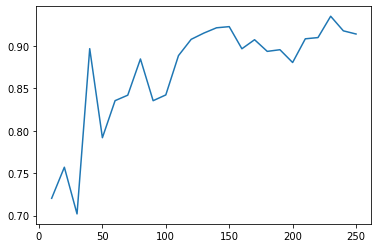

In [145]:
plt.plot(sample_counts,list_of_lists[0])

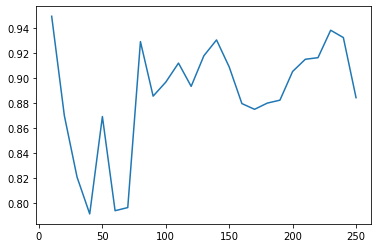

In [146]:
plt.plot(sample_counts,list_of_lists[1])

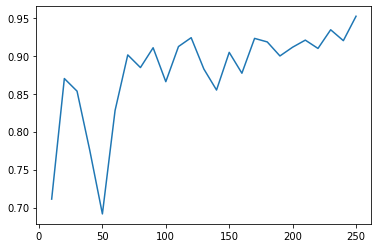

In [147]:
plt.plot(sample_counts,list_of_lists[2])

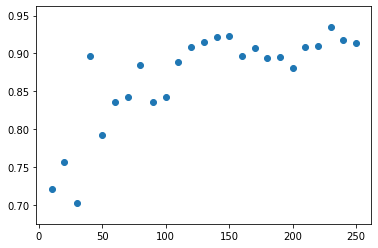

In [148]:
plt.scatter(sample_counts,list_of_lists[0])

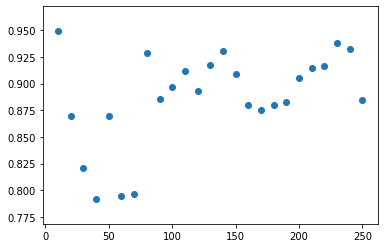

In [149]:
plt.scatter(sample_counts,list_of_lists[1])

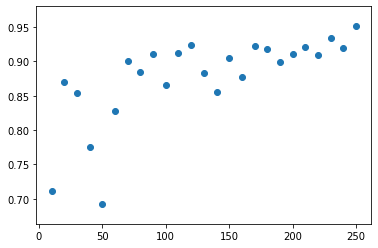

In [150]:
plt.scatter(sample_counts,list_of_lists[1])

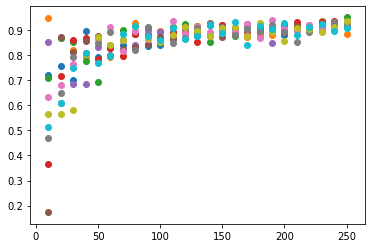

In [151]:
for i in list(range(0,10)):
    plt.scatter(sample_counts,list_of_lists[i])

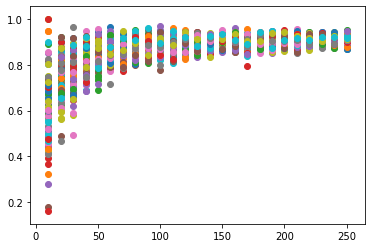

In [152]:
for i in list(range(0,100)):
    plt.scatter(sample_counts,list_of_lists[i])

In [209]:
# Paramter block for single cohort, run curve fit 100 times

lower = [0,-1000,-1]
upper = [.5,1000,0]

def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc

# Initialize dictionary for building parameter table
fits = {}
# for i, cohort in enumerate(counts):
for resampling in list(range(0,100)): # loop of 100
#     print(i)
#     break
    
#     f, _ = curve_fit(Y_acc, counts[cohort], scores[cohort], bounds=[lower,upper])
    f, _ = curve_fit(Y_acc, sample_counts, list_of_lists[resampling], bounds=[lower,upper])
    fits[resampling] = f


In [210]:
fits

{0: array([ 1.29762496e-13,  7.83105047e-01, -3.98976646e-01]),
 1: array([ 3.25280593e-13,  1.92791382e-01, -1.16297356e-01]),
 2: array([ 9.46853859e-14,  6.52887338e-01, -3.72119154e-01]),
 3: array([ 0.06108806,  5.27928317, -1.        ]),
 4: array([ 2.52245708e-16,  7.04808255e-01, -3.55712534e-01]),
 5: array([ 0.04723551,  6.33470193, -1.        ]),
 6: array([ 0.02257101,  1.39760476, -0.58257114]),
 7: array([ 0.06970072,  4.47245812, -0.97841186]),
 8: array([ 4.34100424e-13,  1.86005441e+00, -5.70566004e-01]),
 9: array([ 0.02185402,  2.20368461, -0.65727037]),
 10: array([ 0.01546248,  1.52157307, -0.5762087 ]),
 11: array([ 0.05151896,  1.97954374, -0.75268078]),
 12: array([ 0.07272897,  4.43572671, -1.        ]),
 13: array([ 2.97672044e-17,  9.45305265e-01, -4.28615007e-01]),
 14: array([ 0.0388222 ,  1.07616589, -0.58695789]),
 15: array([ 5.51240412e-13,  7.46960556e-01, -3.81832513e-01]),
 16: array([ 5.73310255e-17,  6.35527355e-01, -3.67040066e-01]),
 17: array([ 

In [211]:
fdf = pd.DataFrame(fits).transpose()
fdf.columns = ['a','b','c']

In [212]:
fdf.shape

(100, 3)

In [213]:
fdf.head()

,a,b,c
0,1.297625e-13,0.783105,-0.398977
1,3.252806e-13,0.192791,-0.116297
2,9.468539e-14,0.652887,-0.372119
3,6.108806e-02,5.279283,-1.000000
4,2.522457e-16,0.704808,-0.355713


In [214]:
# Backstop checkpoint for full BRCA parameter table

In [215]:
# Option to use average of final scores as lin reg target - yes
# last element of average score list - no

In [216]:
# Make a list of 100 y targets, BRCA final scores (position 24 = -1)
final_score = []
for score_list in list_of_lists:
#     print(score_list[-1])
    final_score.append(score_list[-1])
#     break
    # Abandoned, using average final y
    # Rationale: experimental variable is only parameters
    # Control variable is averaged resampling curve

In [217]:
len(final_score)

100

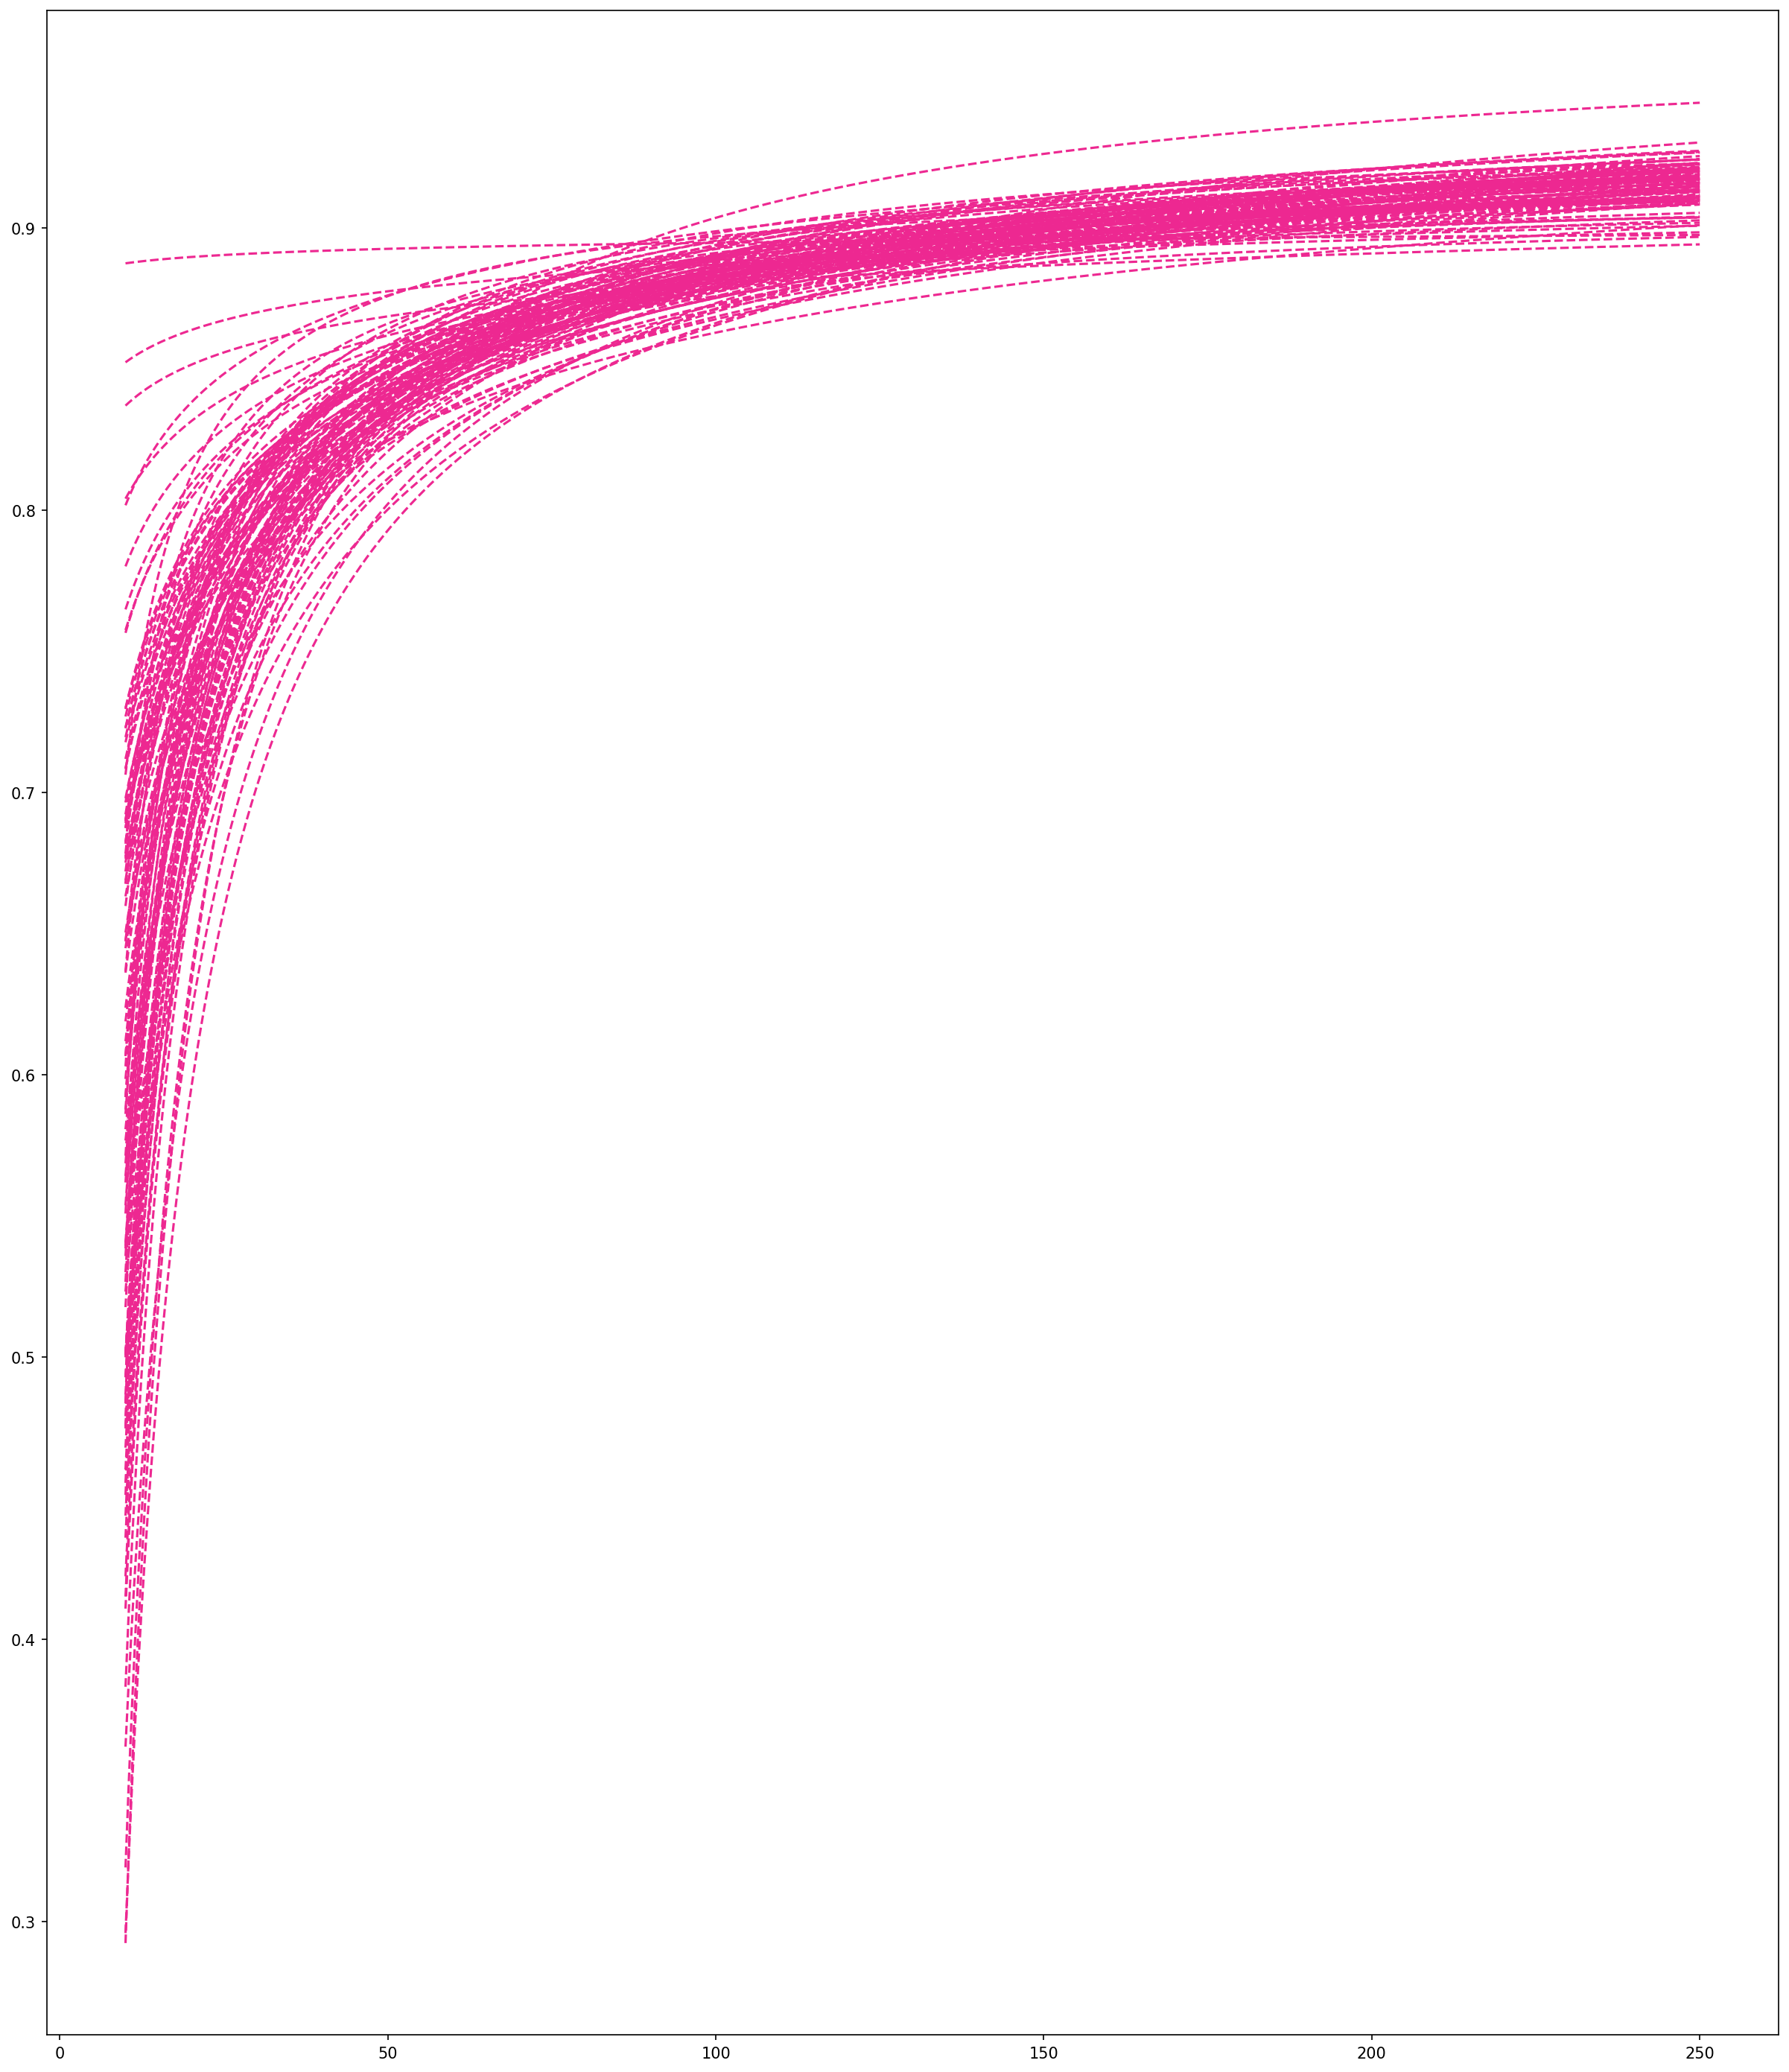

In [208]:
colors = pd.read_csv('TMP_cohort_colors_n26_20210228.csv',
                     sep = ',', skiprows = 1, names = ['Cohort', 'Hexi'])
store_lin_reg_output = []
# BRCA_lin_reg = LinearRegression().fit(fdf, final_scores) # Moved out of loop
fig, ax = plt.subplots(figsize = (20,24), dpi = 150)
for resampling in list(range(0,100)):
    color_shard = colors[colors.Cohort == cohort]
    colr = color_shard.iloc[0,1]
    f, _ = curve_fit(Y_acc, sample_counts, list_of_lists[resampling], bounds=[lower,upper])
    # fit the lin reg (100 times) - no, use the pre-generated parameter table
    
    # predict the lin reg ***** Use first five steps of average - yes
    # store_lin_reg_output.append(round(BRCA_lin_reg.predict(np.array(fdf5.loc[cohort]).reshape(1, -1))[0], 3))
    x = np.linspace(10, 250, 1000)
    y = Y_acc(x, *f)  
    ax.plot(x, y, '--', color=colr)

In [176]:
from sklearn.linear_model import LinearRegression

In [218]:
BRCA_lin_reg = LinearRegression().fit(fdf, final_score)

In [180]:
list_of_lists[resampling][0:5]

[0.9,
 0.6542657342657343,
 0.886891793754539,
 0.8835082990495107,
 0.7867165775401069]

In [248]:
# Rebuild fdf5, use as input for lin reg predictions
upper_end_of_sample_range = 5 # Toggle (n) steps
fits_restrict = {}
for resampling in list(range(0,100)):
    f, _ = curve_fit(Y_acc, sample_counts[0:upper_end_of_sample_range],
                     list_of_lists[resampling][0:upper_end_of_sample_range],
                     bounds=[lower,upper])
    fits_restrict[resampling] = f
fdf_restrict = pd.DataFrame(fits_restrict).transpose()
fdf_restrict.columns = ['a','b','c']

In [249]:
y_hat = []
for observation in fdf_restrict.index:
    y_hat.append(round(BRCA_lin_reg.predict(np.array(fdf_restrict.loc[observation]).reshape(1, -1))[0], 3))

In [ ]:
# Strategy to get to confidence interval:
# Fit lin reg using full parameter table as x
# Final score as y target
# Refit inverse power on first five (n) steps
# Make 100 predcitions on restricted table

In [ ]:
# Create 'sample' object of lin reg predictions to point CI function

In [250]:
sample = y_hat

In [251]:
import math
# xbar is sample mean
# z is 1.96
# s is sample standard deviation, package?
# n is sample size
xbar = mean(sample)
z = 1.96
s = statistics.stdev(sample)
n = len(sample)
CI_upper = xbar + z * (s/math.sqrt(n))
CI_lower = xbar - z * (s/math.sqrt(n))

In [252]:
CI_upper

0.9121803236791439

In [253]:
CI_lower

0.906279676320856

In [ ]:
# End

In [ ]:
# Devel notes for reference

In [ ]:
# Boot strap split (potential alternate method)

In [ ]:
#### Plotting block, in progress
colors = pd.read_csv('TMP_cohort_colors_n26_20210228.csv',
                     sep = ',', skiprows = 1, names = ['Cohort', 'Hexi'])

# Pseudo run the fit loop on the resample scores
#     plt(sample_steps, y_ave)
#     for i in 100:
#         plt(a bunch of curves)

In [247]:
# Template code from inverse_power.ipynb on GitHub
# Get packages, dictionaries, and function set up
# import numpy as np
import json
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# Color file URL:
# https://drive.google.com/file/d/1ZoyP-aMOW2TKFNDQraL5ia3jpe6ZgQdA/view?usp=sharing
colors = pd.read_csv('TMP_cohort_colors_n26_20210228.csv', sep = ',', skiprows = 1, names = ['Cohort', 'Hexi'])

counts = {}
scores = {}
errors = {}
header = None

# Sample count response file URL:
# https://www.synapse.org/#!Synapse:syn25915900
with open("Sample_count_response.tsv") as handle:
    for tmp in handle:
        row = tmp.split("\t")
        if header is None:
            header = row
        else:
            n = row[0]
            c = json.loads(row[1])
            s = json.loads(row[2])
            e = json.loads(row[3])
            counts[n] = c
            scores[n] = s
            errors[n] = e
            
# Define curve fitting function
def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc

# Build parameter table
lower = [0,-1000,-1]
upper = [.5,1000,0]
fits = {}
for i,cohort in enumerate(counts):
    f, _ = curve_fit(Y_acc, counts[cohort], scores[cohort], bounds=[lower,upper])
    fits[cohort] = f
fdf = pd.DataFrame(fits).transpose()
fdf.columns = ['a','b','c']

# Define training for linear regression based on max number samples
samples_250 = []
scores_250 = []
for i,cohort in enumerate(counts): # iterate dictionary returns keys
    if counts[cohort][-1] >= 250: # Toggle line, previously 150
        samples_250.append(cohort)
        scores_250.append(scores[cohort][-1])
reg_250 = LinearRegression().fit(fdf.loc[samples_250], scores_250)

In [250]:
counts

{'ACC': [10, 20, 30, 40, 50, 60, 70],
 'BLCA': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250],
 'BRCA': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250],
 'CESC': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170],
 'COADREAD': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250],
 'ESCC': [10, 20, 30, 40, 50, 60, 70, 80],
 'GEA': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250],
 'HNSC': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,


In [249]:
cohort

'UVM'

In [248]:
 scores[cohort] # y

[0.622, 0.787, 0.857, 0.888, 0.911, 0.931, 0.947]

In [246]:
counts[cohort] # x

[10, 20, 30, 40, 50, 60, 70]

In [ ]:
fits5 = {}
for cohort in counts:
    f, _ = curve_fit(Y_acc, counts[cohort][:5], scores[cohort][:5], bounds=[lower,upper])
    fits5[cohort] = f
fdf5 = pd.DataFrame(fits5).transpose()
fdf5.columns = ['a_test','b_test','c_test']

y_hat = []
for cohort in fdf5.index:
    y_hat.append(round(reg_250.predict(np.array(fdf5.loc[cohort]).reshape(1, -1))[0], 3))

In [ ]:
# Final predicted scores based on inverse power law paramters of
# first 5 sample step sizes using linear regression model fit to
# inverse power law parameters of the 15 cohorts with at least 250 samples

Final_scores = pd.DataFrame()
y_true = []
cohort_list = []
for cohort in counts:
    cohort_list.append(cohort)
    if counts[cohort][-1] == 250:
        y_true.append(scores[cohort][-1])
    else:
        y_true.append('N/A')
Final_scores['Cohort'] = cohort_list
Final_scores['Y_hat'] = y_hat
Final_scores['Y_true'] = y_true

In [ ]:
# Plot fitted curves vs. raw data
fig, ax = plt.subplots(figsize = (20,24), dpi = 150)

# Adjust individual cohort labels up and down
offset = [ -.005, -.015, -.008, -.005, -.021,
        #           BLCA        CESC  COADREAD  
          0, -.011, .001,  0,  -.008,
        #     GEA   HNSC       KIRP
          -.009, -.016, -.008, -.014, -.005, -.008,
          
          -.002,   0,   0,  -.006,  0,
#                           SARC
          -.01, .009, -.01, -.006, -.01]
#                            UCEC

# Adjust individual cohort labels side to side
left_shift = [0,  -10,  0,  0,  0,  0,  -9  ,2  ,0,0,
          #                             GEA
             0, 0, 2, 0, 0, 0, 0, 0 ,0, 0,
              
             0,  0,  2,  0,  0,  0]

left_tab = 100
middle_tab = 120
right_tab = 145

y_pos = .56
fs = 12
ax.text(left_tab, y_pos, 'Cohort', fontsize = 12)
ax.text(middle_tab, y_pos+.016, 'Predicted F1', fontsize = 12)
ax.text(middle_tab, y_pos+.008, 'score at 250', fontsize = 12)
ax.text(middle_tab, y_pos, 'samples', fontsize = 12)

ax.text(right_tab, y_pos+.008, 'Actual F1 score', fontsize = 12)
ax.text(right_tab, y_pos, 'at 250 samples', fontsize = 12)

for i,cohort in enumerate(counts): # Use inverse power law function and bounds from block 1
    f, _ = curve_fit(Y_acc, counts[cohort], scores[cohort], bounds=[lower,upper])
    color_shard = colors[colors.Cohort == cohort]
    colr = color_shard.iloc[0,1]
    ax.plot(counts[cohort], scores[cohort], 'o', c = colr)
    ax.text(counts[cohort][-1]+left_shift[i], scores[cohort][-1]+offset[i],
#     ax.text(counts[cohort][-1], scores[cohort][-1],  # Toggle offset and shift      
            cohort,
            fontsize = 14,va='center',
           bbox = dict(facecolor='white', edgecolor=colr, boxstyle='round,pad=0.15'))
    x = np.linspace(10, 250, 1000)
    y = Y_acc(x, *f)  
    ax.plot(x, y, '--', color=colr)
    
    y_pos = y_pos - .013
    
    ax.text(left_tab, y_pos, str(Final_scores.iloc[i,0]), fontsize = fs, color = colr, weight='bold')
    ax.text(middle_tab, y_pos, str(Final_scores.iloc[i,1]), fontsize = fs, color = colr, weight='bold')
    ax.text(right_tab, y_pos, str(Final_scores.iloc[i,2]), fontsize = fs, color = colr, weight='bold')
    
# Print inverse power law on plot
ax.text(110, .62, 'Inverse power law function\nfor curve fitting:', fontsize = 15)
ax.text(110, .6, r'$Y_{acc} = (1-a)-b(x^c)$', fontsize = 16)

ax.text(180, .57, 'Predicted scores based on inverse power\nlaw model parameters of first five '
'sample\nstep sizes using linear regression model\nfit to the 15 cohorts with at least\n250 samples', fontsize = 15)

fig.suptitle('Accuracy convergence vs. sample count', y = .87,fontsize = 17)
ax.set_xlabel('n Samples', fontsize = 15)
ax.set_ylabel('F1 accuracy', fontsize = 15)
# plt.savefig('Inverse_power.png',dpi=300)
plt.show()

In [ ]:
# Fail - abandoned: Score for each repeat fold / sample step combo:
path_list = sorted(glob.glob('../20210721_exacloud_results/*.tsv'))
sample_counts = []
average_scores = []
for path in path_list:
    file = pd.read_csv(path, sep = '\t')
    cohort = path.split('/')[2].split('.')[0]
    print(cohort)
    if cohort != 'ACC':
        continue
    sample_size = int(path.split('.')[5])
    sample_counts.append(sample_size)
    # make a list of lists
    # 100 scores for each of 10 repeats at each sample step size
    resample_scores = []
    
    test = file[file['Test'] == 1].copy()
    test.reset_index(inplace = True, drop = True)
    
    # Goal is to get like chunks of row for scoring
    test['RF'] = test.Repeat + test.Fold
    stop = len(test)
    scoreDF = pd.DataFrame(test.iloc[0,:]).T
    for i in test.index:
#         while i <= stop:
        rf = test.iloc[i,6]
        rf_plus = test.iloc[i+1,6]
        if rf != rf_plus: # take score if next row is different
            score = f1_score(scoreDF.iloc[:,4],
                 scoreDF.iloc[:,5],
                 average='weighted')
            resample_scores.append(score)
            scoreDF = pd.DataFrame(test.iloc[i+1,:]).T # 
        else:
            scoreDF_plus = pd.DataFrame(test.iloc[i+1,:]).T
            scoreDF = pd.concat([scoreDF, scoreDF_plus])
            
#         if i == 3:
#             break
        if i == stop-2:    
            break
#     break
    average_scores.append(mean(resample_scores))
    print('sample step done')
    
    if sample_size == 10:
        break
    
    if cohort == 'BRCA':
        break
print('all done')    
def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc    
    
#     plt(true)
#     for i in 1000:
#         plt(a bunch of curves)
# done

In [ ]:
# Code shelf
for repeat_fold in uniqueRFs:
    uniqueRFs = file.RF.unique()
    RF_sub = file[file['RF'] == repeat_fold]
x_sub = RF_sub.iloc[:, 4]
y_sub = RF_sub.iloc[:, 5]

In [ ]:
# Scoring block, template code from sample_count_reproduce
# Goal is get summary stats to check predicition script
# Connect to original figure
# Fit Curve to each cross fold

path_list = sorted(glob.glob('../results_test/'+cancer+'*.tsv'))

from sklearn.metrics import f1_score

# import math # to scoring block
# import statistics # to scoring block

sample_counts = [] # Now get from path
scores = [] # Storage list for scores at different sample counts
errors = []
run_times = []

sample_count = 10
# score = .9
stdev = .17
for path in path_list:
    
    cohort = path.split('/')[2].split('_')[0]
    sample_count = path.split('.')[-2]
    print(sample_count)
    date = path.split('_')[2]
    run_time = path.split('.')[3].split('_')[0] # Fix for dot in BRCA naming
    
    Cohort_test_n = pd.read_csv(path, sep = '\t')
    test_set = Cohort_test_n[Cohort_test_n.Test == 1]
    print(len(test_set))
    score = f1_score(test_set.iloc[:,4],
                 test_set.iloc[:,5],
                 average='weighted')

# Get standard deviation from list of F1 scoreson each repeat fold 
# Need to subset test_set by repeat folds then call F1 score inner loop

#     score.append(round(score, 3))
    sample_counts.append(int(sample_count))
    scores.append(round(score, 3))
    errors.append(stdev)
    run_times.append(int(run_time))
    #     break
    
# Make DataFrame from list of lists and list of columns
# One row frame?
score_frame = pd.DataFrame([[cohort, sample_counts, scores, errors]],
                           columns=['Cancer', 'Sample_counts', 'Rate_scores', 'Error'])
score_frame.to_csv(
#              cohort+'_'+date+'_'+str(sample_count)+'.tsv',
    
                # Append last sample step size completed to determine next parallelization step
             cohort+'_'+date+'.tsv',    
                      index=None, sep='\t')

In [ ]:
# z_fill template
z_list = [10,20,40,90,100,1,8]
filled_list = []
for i in z_list:
    filled_list.append(str(i).zfill(3))
filled_list

In [ ]:
plt.scatter(sample_counts, scores)
plt.title(cohort + ' F1 score')

In [ ]:
plt.scatter(sample_counts, run_times)
plt.title(cohort + ' runtime')

In [ ]:
plt.scatter(sample_counts, run_times)
plt.title(cohort + ' runtime')

In [ ]:
plt.scatter(sample_counts, run_times)
plt.title(cohort + ' runtime')

In [ ]:
# Template code for progress meter
resampling = 10
pd.DataFrame(data = {'Resampling_number': resampling}, index = [0])

In [ ]:
progress_meter = pd.DataFrame(data = {'Resampling_number': resampling},
                                     index = [0])
progress_meter.to_csv( 'Resampling_number.' + str(resampling) + '.tsv',
sep = '\t')

In [ ]:
stdv = statistics.stdev(rpt_scores)
errors.append(stdv)

y_true_str=test_set.Label
y_true=[]
for k in y_true_str:
    splt=k.split('_')
    y_str_ele=splt[1]
    y_int_ele=int(y_str_ele)
    y_true.append(y_int_ele)

col=test_set.iloc[:,5]
y_pred=[]
for j in col:
    splt=j.split('_')
    y_str_ele=splt[1]
    y_int_ele=int(y_str_ele)
    y_pred.append(y_int_ele)

score=f1_score(y_true,y_pred,average='weighted')